In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Input, LSTM, Dot, Concatenate
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras import backend as K
import tensorflow_probability as tfp

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import rc, cm
plt.rcParams.update({'pdf.fonttype': 'truetype'})

## 데이터 생성하기

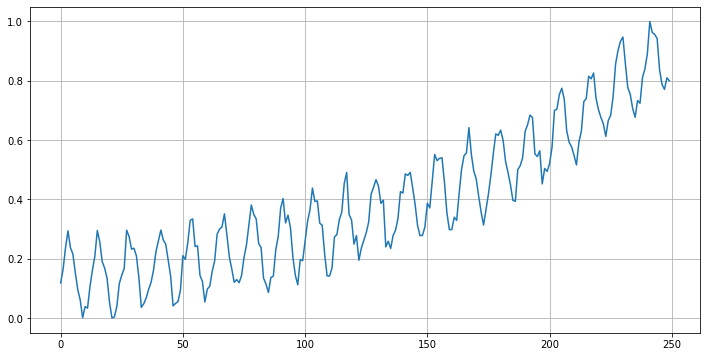

In [2]:
#%%
n_time_steps = 250
index = np.arange(n_time_steps)
s = np.sin(index/2) + np.exp(index/n_time_steps * 2.0)
s += np.random.normal(0, 0.2, n_time_steps)
scaler = MinMaxScaler(feature_range=(0, 1))
s = scaler.fit_transform(s.reshape(-1, 1))[:,0]
# 크기 조정.
# 신경망에 입력을 위해서는 reshape(-1, 1)을 통해 차원 조정 필요함.
fig, ax = plt.subplots(1, figsize = (12, 6))
ax.plot(s)
ax.grid(True)

In [3]:
def series_to_dataset(s, input_width, label_offset, label_width):
    # input_width : 시계열 데이터를 자를 간격
    # label_offset : 몇 시간 간격 뒤를 예측할 건가
    # label_width : 예측을 할 시계열 데이터의 길이
    
    x, y = [], []
    for i in range(len(s) - input_width - label_width - label_offset):
        w = s[i : (i + input_width)]
        x.append(w)
        y.append(s[i + input_width + label_offset : i + input_width + label_offset + label_width])
    return np.array(x), np.array(y)

# time series를 train/test datasets로 변환
def create_dataset(s, train_test_ratio, input_width, label_offset = 0, label_width = 1): 
    #
    # Split the series into train and test datasets
    #
    train_size = int(len(s) * train_test_ratio)
    test_size = len(s) - train_size
    train, test = s[:train_size], s[train_size:]
    print(f'Train set: {len(train)} samples, test set: {len(test)} samples')
    
    x_train, y_train = series_to_dataset(train, input_width, label_offset, label_width)
    x_test, y_test = series_to_dataset(test, input_width, label_offset, label_width)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return (x_train, y_train), (x_test, y_test)

def plot_forecast(index, s, input_width, label_offset, y_train_pred, y_test_pred):
    label_width = y_train_pred.shape[1]
    fig, ax = plt.subplots(1, figsize=(12, 6))
    ax.plot(s, label = 'Ground truth')
    for i in range(label_width):
        ax.plot(index[input_width + label_offset + i : len(y_train_pred) + input_width + label_offset + i], y_train_pred[:, i], label = 'Predicted, training set')
        ax.plot(index[-(len(y_test_pred)+i):len(index)-i], y_test_pred[:, label_width - i - 1], label = 'Predicted, test set')
    ax.grid(True)
    ax.legend()

def plot_history(history):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax.plot(history.history['val_mape'])
    ax.grid(True)
    ax.set_title(f"Mean validation MAPE for last 30 epochs = {np.mean(history.history['val_mape'][-30:])}" )

## Linear Model

Train set: 175 samples, test set: 75 samples
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


2022-09-03 10:25:48.088953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-03 10:25:48.089078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-09-03 10:25:48.163151: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-03 10:25:48.314460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:25:48.609469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 2ms/step


2022-09-03 10:27:16.474568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


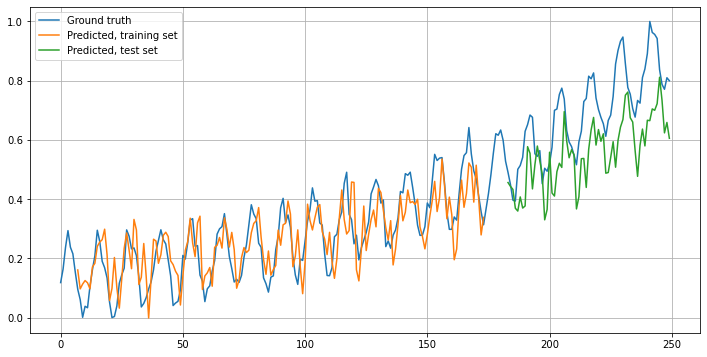

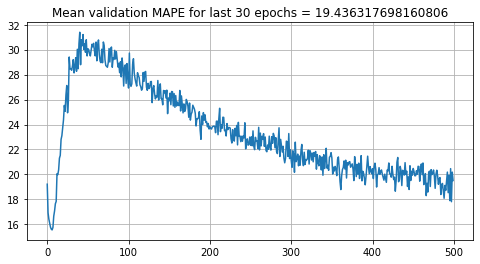

In [4]:
n_lags = 5
label_offset = 2
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio=0.7, input_width=n_lags, label_offset=label_offset)

input_layer = Input(shape=(n_lags, 1)) # mini_batch는 3d tensor 형태이다.
linear_1 = Dense(1)(Flatten()(input_layer))
model_linear = Model(inputs=input_layer, outputs=linear_1)

model_linear.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_linear.summary()
history = model_linear.fit(x_train, y_train, epochs=500, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_linear.predict(x_train)
y_test_pred = model_linear.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

## Dense Model

Train set: 175 samples, test set: 75 samples
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


2022-09-03 10:27:16.879866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:27:17.229440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step


2022-09-03 10:29:06.626738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


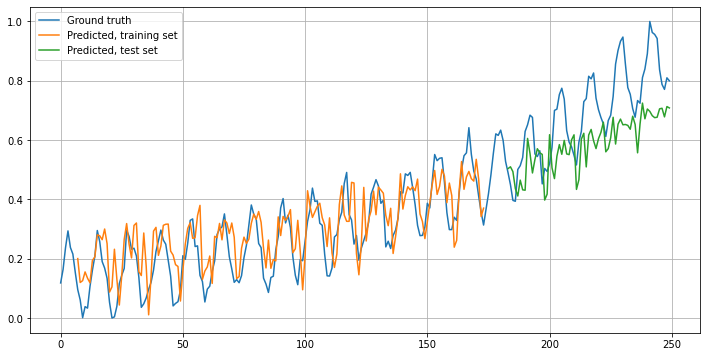

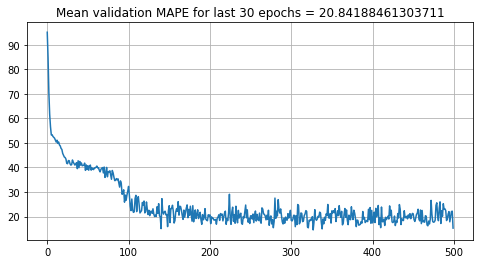

In [5]:
n_lags = 5
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags, label_offset = 2)

#
# Specify the model
#
input_layer = Input(shape=(n_lags, 1))
dense_1 = Dense(n_lags, activation='relu')(Flatten()(input_layer))
dense_2 = Dense(n_lags, activation='relu')(dense_1)
dense_3 = Dense(1)(dense_2)
model_dense = Model(inputs=input_layer, outputs=dense_3)

model_dense.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_dense.summary()
history = model_dense.fit(x_train, y_train, epochs=500, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_dense.predict(x_train)
y_test_pred = model_dense.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

## Convolution Model

Train set: 175 samples, test set: 75 samples
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 3)              18        
                                                                 
 flatten_2 (Flatten)         (None, 3)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


2022-09-03 10:29:07.014871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:29:07.317829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 3ms/step


2022-09-03 10:30:41.456327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


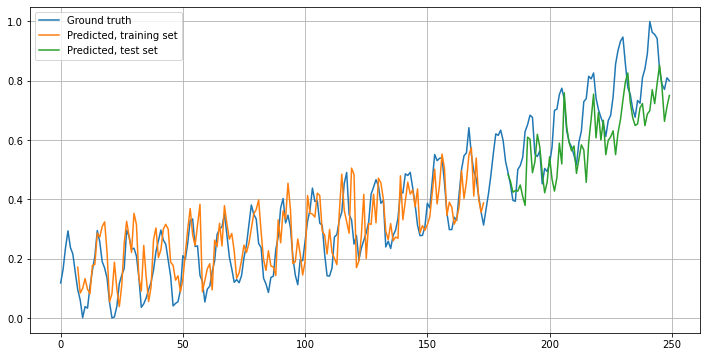

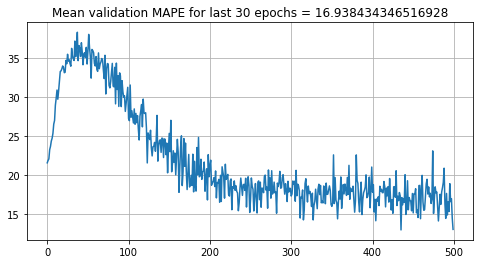

In [6]:
n_lags = 5
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags, label_offset = 2)

#
# Specify the model
#
conv_width = 5
input_layer = Input(shape=(n_lags, 1))
dense_1 = layers.Conv1D(filters=3, kernel_size=(conv_width,), activation='relu')(input_layer)
dense_2 = Dense(1)(Flatten()(dense_1))
model_conv = Model(inputs=input_layer, outputs=dense_2)

model_conv.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_conv.summary()
history = model_conv.fit(x_train, y_train, epochs=500, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_conv.predict(x_train)
y_test_pred = model_conv.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

## LSTM Model

Train set: 175 samples, test set: 75 samples
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 lstm (LSTM)                 [(None, 5, 4),            96        
                              (None, 4),                         
                              (None, 4)]                         
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


2022-09-03 10:30:42.617394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:30:42.785104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:30:42.867497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:30:43.433767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:30:43.501698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 7ms/step


2022-09-03 10:33:28.310710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:33:28.366759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


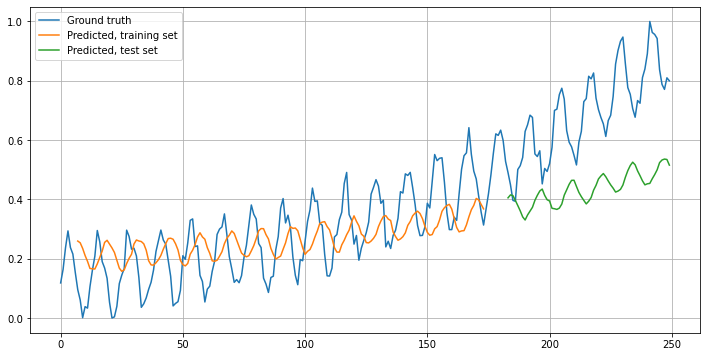

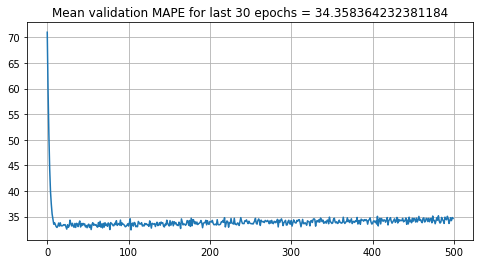

In [7]:
n_lags = 5
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags, label_offset = 2)

#
# Specify the model
#
hidden_units = 4
input_model = Input(shape=(n_lags, 1))
lstm_state_seq, state_h, state_c = LSTM(hidden_units, return_sequences=True, return_state=True)(input_model)
output_dense = Dense(1)(state_c)
model_lstm = Model(inputs=input_model, outputs=output_dense)

model_lstm.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_lstm.summary()
history = model_lstm.fit(x_train, y_train, epochs=500, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_lstm.predict(x_train)
y_test_pred = model_lstm.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

## LSTM with Attention

Train set: 175 samples, test set: 75 samples
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 5, 3)         60          ['input_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 5, 1)         4           ['lstm_1[0][0]']                 
                                                                                                  
 flatten_3 (Flatten)            (None, 5)            0           ['dense_6[0][0]']                
                                               

2022-09-03 10:33:29.485721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:33:29.676234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:33:29.792771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:33:30.486952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:33:30.557805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/3 [=========>....................] - ETA: 0s

2022-09-03 10:35:47.179657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:35:47.249269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 6ms/step
Weight matrix shape (169, 5)


2022-09-03 10:35:47.561813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-03 10:35:47.618846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


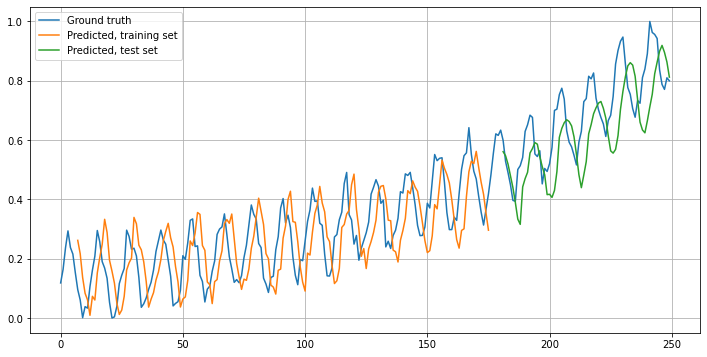

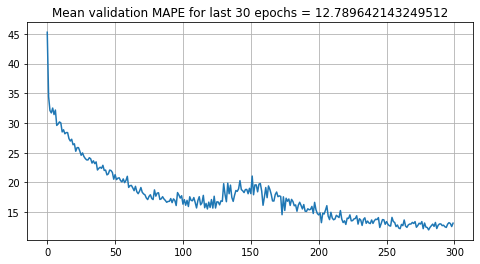

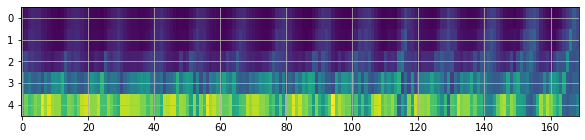

In [8]:
n_lags = 5
(x_train, y_train), (x_test, y_test) = create_dataset(s, train_test_ratio = 0.7, input_width = n_lags)

hidden_units = 3
main_input = Input(shape=(n_lags, 1))
activations = LSTM(hidden_units, return_sequences=True)(main_input)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

main_output = Dense(1)(weighted_activations)

model_attn = Model(inputs=main_input, outputs=main_output)

model_attn.compile(loss='mean_squared_error',  metrics=['mape'], optimizer='adam')
model_attn.summary()
history = model_attn.fit(x_train, y_train, epochs=300, batch_size=4, validation_data=(x_test, y_test), verbose=0)

#
# Predict values over the train and test ranges
#
y_train_pred = model_attn.predict(x_train)
y_test_pred = model_attn.predict(x_test)

plot_forecast(index, s, n_lags, label_offset, y_train_pred, y_test_pred)
plot_history(history)

#
#  evaluate atention weights for each time step
#
attention_model = Model(inputs=model_attn.input, outputs=model_attn.get_layer('attention_weigths').output)
a = attention_model.predict(x_train)
print(f'Weight matrix shape {a.shape}')

fig, ax = plt.subplots(1, figsize=(10, 2))
ax.imshow(a.T, cmap='viridis', interpolation='nearest', aspect='auto')
ax.grid(None)